<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computational Seismology</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Reproducible Papers - Syngine Paper</div>
        </div>
    </div>
</div>

---

# Figure 3: Finite Source Seismograms

This notebook is part of the supplementary materials for the Syngine paper and reproduces figure 3.

This notebook creates the finite source seismograms figure. Requires matplotlib >= 1.5 and ObsPy as well as instaseis.

##### Authors:
* Lion Krischer ([@krischer](https://github.com/krischer))

In [1]:
%matplotlib inline

import obspy
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn-whitegrid")

import copy
import io
import instaseis
import json

import requests

/Users/lion/.miniconda/envs/seismo_live/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/lion/.miniconda/envs/seismo_live/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
SYNGINE_URL = "http://service.iris.edu/irisws/syngine/1/query"
MODEL = "ak135f_5s"

Get the station coordinates

In [3]:
network = "IU"
station = "ANMO"

# Get some real station information using the ObsPy FDSN client.
from obspy.clients.fdsn import Client
c = Client("IRIS")
print(c.get_stations(network=network, station=station, format="text")[0][0])

Station ANMO (Albuquerque, New Mexico, USA)
	Station Code: ANMO
	Channel Count: None/None (Selected/Total)
	1989-08-29T00:00:00.000000Z - 1995-07-14T00:00:00.000000Z
	Access: None 
	Latitude: 34.95, Longitude: -106.46, Elevation: 1850.0 m
	Available Channels:



In [4]:
# Define all parameters by reading the USGS param file.
filename = "chile_param.txt"

# Parse the finite source and compute the centroid.
finite_source = instaseis.FiniteSource.from_usgs_param_file(filename)
finite_source.compute_centroid()

src = finite_source.CMT

# Common query parameters.
params_common = {
    # IU.ANMO
    "receiverlatitude": 34.95,
    "receiverlongitude": -106.46,
    "dt": 0.1,
    "origintime": src.origin_time,
    "components": "Z",
    "format": "miniseed",
    "model": MODEL,
    "units": "velocity"}

# Parameters only needed for the point source.
# Use the centroid as the source parameters.
params_ps = copy.deepcopy(params_common)
params_ps["sourcelatitude"] = src.latitude
params_ps["sourcelongitude"] = src.longitude
params_ps["sourcedepthinmeters"] = src.depth_in_m
params_ps["sourcemomenttensor"] = ",".join(
    str(getattr(src, _i)) for _i in ("m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp"))

print(finite_source)
print(finite_source.CMT)

Instaseis Finite Source:
	Moment Magnitude     : 8.26
	Scalar Moment        :   2.49e+21 Nm
	#Point Sources       : 400
	Rupture Duration     :   97.6 s
	Time Shift           :    0.8 s
	Min Depth            : 10832.8 m
	Max Depth            : 70943.4 m
	Hypocenter Depth     : 70943.4 m
	Min Latitude         :  -20.8 deg
	Max Latitude         :  -18.4 deg
	Hypocenter Latitude  :  -19.6 deg
	Min Longitude        :  -71.7 deg
	Max Longitude        :  -69.5 deg
	Hypocenter Longitude :  -71.0 deg

Instaseis Source:
	Origin Time      : 1970-01-01T00:00:00.000000Z
	Longitude        :  -70.6 deg
	Latitude         :  -19.6 deg
	Depth            : 3.6e+01 km km
	Moment Magnitude :   8.24
	Scalar Moment    :   2.30e+21 Nm
	Mrr              :   1.38e+21 Nm
	Mtt              :  -1.02e+20 Nm
	Mpp              :  -1.27e+21 Nm
	Mrt              :   6.45e+20 Nm
	Mrp              :  -1.73e+21 Nm
	Mtp              :   3.62e+20 Nm



XX.S0001.SE.BXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T01:04:39.900000Z | 10.0 Hz, 38800 samples


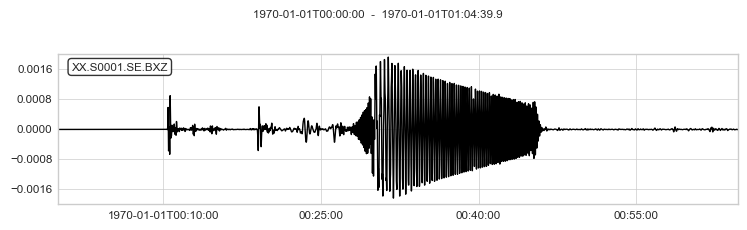

XX.S0001.SE.BXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T01:04:39.900000Z | 10.0 Hz, 38800 samples


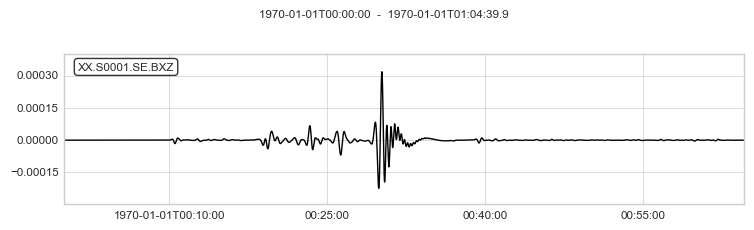

In [5]:
# Get point source seismogram.
r = requests.get(url=SYNGINE_URL, params=params_ps)
assert r.ok, str(r.reason)
with io.BytesIO(r.content) as f:
    tr_ps = obspy.read(f)[0]
    
print(tr_ps)
tr_ps.plot()

# Point source with 50 sec STF
p = copy.deepcopy(params_ps)
p["sourcewidth"] = 50
r = requests.get(url=SYNGINE_URL, params=p)
assert r.ok, str(r.reason)
with io.BytesIO(r.content) as f:
    tr_ps_50 = obspy.read(f)[0]
    
print(tr_ps_50)
tr_ps_50.plot()

IU.ANMO.SE.LXZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T01:04:36.100000Z | 10.0 Hz, 38762 samples


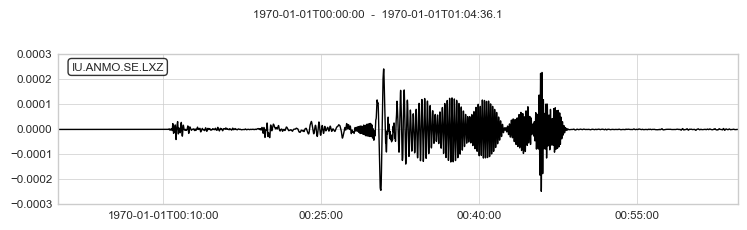

In [6]:
# Now get the finite source seismogram by generating 
# a POST request with the embedded USGS param file.
buf = """IU ANMO
dt=0.1
origintime=%s
components=Z
format=miniseed
model=%s
units=velocity
STARTUSGSFFM
""" % (str(src.origin_time), MODEL)

buf = buf.encode()

with open(filename, "rb") as fh:
    buf += fh.read()
    
buf += b"ENDUSGSFFM"

# Actually get the data and parse with ObsPy.
r = requests.post(url=SYNGINE_URL, data=buf)
assert r.ok, str(r.reason)
with io.BytesIO(r.content) as f:
    tr_fs = obspy.read(f)[0]
    
print(tr_fs)
tr_fs.plot()

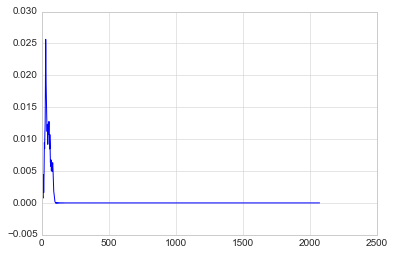

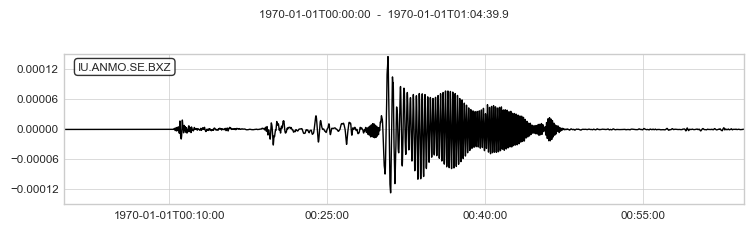

In [7]:
# Get a seismogram with a point-source but a finite-source derived 
# STF.
finite_source = instaseis.FiniteSource.from_usgs_param_file(filename)
finite_source.resample_sliprate(1.3, 2000)
finite_source.compute_centroid()

stf = {
    "units": "moment_rate",
    "relative_origin_time_in_sec": 5.0,
    "sample_spacing_in_sec": finite_source.CMT.dt,
    "data": list(finite_source.CMT.sliprate)
}
# Force beginning and end to be zero.
stf["data"][0] = 0
stf["data"][-1] = 0

buf = """IU ANMO
dt=0.1
origintime=%s
components=Z
format=miniseed
model=%s
units=velocity
sourcelatitude=%f
sourcelongitude=%f
sourcedepthinmeters=%f
sourcemomenttensor=%s
cstf-relative-origin-time-in-sec=%f
cstf-sample-spacing-in-sec=%f
cstf-data=%s
""" % (str(src.origin_time), 
       MODEL,
       src.latitude,
       src.longitude,
       src.depth_in_m,
       ",".join(str(getattr(src, _i)) for _i in ("m_rr", "m_tt", "m_pp", "m_rt", "m_rp", "m_tp")),
       stf["relative_origin_time_in_sec"],
       stf["sample_spacing_in_sec"], ",".join("%.5f" % abs(i) for i in stf["data"]))

plt.plot(stf["data"])
plt.show()

r = requests.post(url=SYNGINE_URL, data=buf.encode())
assert r.ok, str(r.reason) + str(r.content)
with io.BytesIO(r.content) as f:
    tr_ps_stf = obspy.read(f)[0]
    
tr_ps_stf.plot()

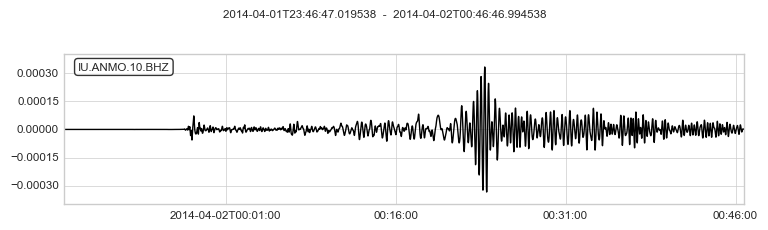

In [8]:
# Get observed data.
from obspy.clients.fdsn import Client
c = Client("IRIS")

event_time = obspy.UTCDateTime("2014-04-01T23:46:47")

tr_obs = c.get_waveforms(network="IU", station="ANMO", 
                         location="10", channel="BHZ", 
                         starttime=event_time, 
                         endtime=event_time + 3600,
                         attach_response=True)[0]
tr_obs.trim(starttime=event_time)
tr_obs.remove_response(water_level=50, output="VEL", pre_filt=(0.005, 0.01, 0.1, 0.2))
tr_obs.plot()

In [9]:
info = requests.get(SYNGINE_URL.replace("query", "info"), params={"model": MODEL}).json()

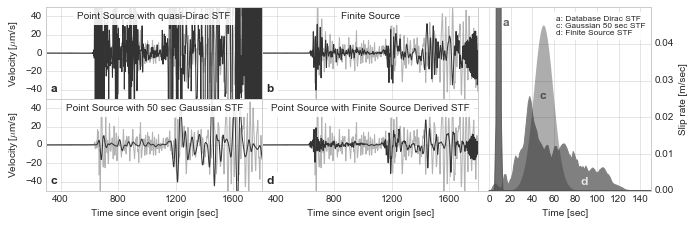

In [11]:
# This cell combines everything into one plot.
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3))

gs1 = gridspec.GridSpec(2, 1, wspace=0, hspace=0, left=0.1, right=0.40, bottom=0.13, top=0.98)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])


gs2 = gridspec.GridSpec(2, 1, wspace=0, hspace=0, left=0.40, right=0.70, bottom=0.13, top=0.98)
ax3 = fig.add_subplot(gs2[0])
ax4 = fig.add_subplot(gs2[1])

gs3 = gridspec.GridSpec(1, 1, wspace=0, hspace=0, left=0.70, right=0.94, bottom=0.13, top=0.98)
ax5 = fig.add_subplot(gs3[0])

props = dict(facecolor='white', alpha=0.9, edgecolor="None")

tr = tr_ps
plt.sca(ax1)
plt.text(x=0.5, y=0.95, s="Point Source with quasi-Dirac STF", ha="center", va="top", 
         transform=ax1.transAxes, bbox=props)
plt.text(x=0.02, y=0.05, s="a", ha="left", va="bottom", fontsize="larger", 
         fontweight="900", transform=ax1.transAxes, bbox=props)
plt.plot(tr_obs.times(), tr_obs.data * 1E6, color="0.7", linewidth=1)
# Undo time correction
plt.plot(tr.times() + info["src_shift"], tr.data * 1E6, color="0.2", linewidth=1, label="point source")
plt.xlim(300, 1800)
plt.ylim(-50, 50)
plt.xlabel("Time since event origin [sec]")
plt.ylabel("Velocity [$\mu$m/s]")
plt.xticks([400, 800, 1200, 1600])
ax1.set_xticklabels([])

plt.sca(ax2)
tr = tr_ps_50
plt.text(x=0.5, y=0.95, s="Point Source with 50 sec Gaussian STF", ha="center", va="top", 
         transform=ax2.transAxes, bbox=props)
plt.text(x=0.02, y=0.05, s="c", ha="left", va="bottom", fontsize="larger", 
         fontweight="900", transform=ax2.transAxes, bbox=props)
plt.plot(tr_obs.times(), tr_obs.data * 1E6, color="0.7", linewidth=1)
# Undo time correction.
plt.plot(tr.times() + 50.0, tr.data * 1E6, color="0.2", linewidth=1, label="point source with 50 sec")
plt.xlim(300, 1800)
plt.xticks([400, 800, 1200, 1600])
plt.ylim(-50, 50)
plt.ylabel("Velocity [$\mu$m/s]")
plt.xlabel("Time since event origin [sec]")

tr = tr_fs
plt.sca(ax3)
plt.text(x=0.5, y=0.95, s="Finite Source", ha="center", va="top", 
         transform=ax3.transAxes, bbox=props)
plt.text(x=0.02, y=0.05, s="b", ha="left", va="bottom", fontsize="larger", 
         fontweight="900", transform=ax3.transAxes, bbox=props)
plt.plot(tr_obs.times(), tr_obs.data * 1E6, color="0.7", linewidth=1)
plt.plot(tr.times(), tr.data * 1E6, color="0.2", linewidth=1, label="finite source")
plt.xlim(300, 1800)
plt.xticks([400, 800, 1200, 1600])
plt.ylim(-50, 50)
plt.xlabel("Time since event origin [sec]")
ax3.set_xticklabels([])
ax3.set_yticklabels([])

plt.sca(ax4)
tr = tr_ps_stf
plt.text(x=0.5, y=0.95, s="Point Source with Finite Source Derived STF", ha="center", va="top", 
         transform=ax4.transAxes, bbox=props)
plt.text(x=0.02, y=0.05, s="d", ha="left", va="bottom", fontsize="larger", 
         fontweight="900", transform=ax4.transAxes, bbox=props)
plt.plot(tr_obs.times(), tr_obs.data * 1E6, color="0.7", linewidth=1)
plt.plot(tr.times(), tr.data * 1E6, color="0.2", linewidth=1, label="point source with stf")
plt.xlim(300, 1800)
plt.xticks([400, 800, 1200, 1600])
plt.ylim(-50, 50)
plt.xlabel("Time since event origin [sec]")
ax4.set_yticklabels([])

plt.sca(ax5)
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position("right")
sr = finite_source.CMT.sliprate 
dt = finite_source.CMT.dt
plt.fill_between(np.arange(len(sr)) * dt, sr, color="0.5")

from instaseis.server.util import get_gaussian_source_time_function

sr2 = get_gaussian_source_time_function(50.0, dt)[1]
sr2 = np.concatenate([sr2, np.zeros(1000)])

plt.fill_between(np.arange(len(sr2)) * dt, sr2, color="0.2", alpha=0.4, linewidth=0)

sr3 = np.array(info["slip"])
dt = np.array(info["dt"])
plt.fill_between(np.arange(len(sr3)) * dt, sr3, color="0.3", alpha=0.8)

l = np.arange(500)
l -= 50
plt.plot(l, np.zeros(500), color="k")

plt.text(x=13, y=0.045, s="a", color="0.4", fontweight=900, fontsize="large")
plt.text(x=50, y=0.025, s="c", color="0.3", fontweight=900, fontsize="large", ha="center")
plt.text(x=85, y=0.0015, s="d", color="0.9", fontweight=900, fontsize="large")

plt.xlim(-10, 150)
plt.ylim(-0.000, 0.05)
plt.yticks([0, 0.01, 0.02, 0.03, 0.04])
plt.xlabel("Time [sec]")
plt.ylabel("Slip rate [m/sec]")

props = dict(facecolor='white', alpha=0.9, edgecolor="None")

plt.text(x=0.45, y=0.95, s="a: Database Dirac STF\nc: Gaussian 50 sec STF\nd: Finite Source STF", 
         ha="left", va="top",  transform=ax5.transAxes, bbox=props, fontsize="small")


plt.savefig("finite_source_seismograms.pdf")

plt.show()